<a href="https://colab.research.google.com/github/Sirawit-Tha/TrainDataML/blob/main/AssignM02_6710025006_Sirawit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stationarity

<img src="https://filippomb.github.io/python-time-series-handbook/_images/cover1.png" style="width: 40%; display: block; margin: auto;">

## Introduction

- Previously, we learned that time series is data that is measured at equally-spaced intervals.
- We also learned that time series data can be decomposed into three parts: trend, seasonality, and residuals.
- Now we'll dig deeper by discussing an important concept called **stationarity**.
- Having a firm grasp of this concept will lay the foundation necessary to understand more advanced modeling strategies that we'll introduce later on.

In this lecture we will cover
- Definition of stationarity and examples of common stationary and nonstationary time series.
- How to detect stationarity.
- The most common ways to transform nonstationary time series into stationary ones.

In [ ]:
# Imports
import warnings
warnings.filterwarnings('ignore')
from io import BytesIO
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.datasets import co2, get_rdataset
from statsmodels.tsa.filters.hp_filter import hpfilter
np.random.seed(0) # Reproducibility

---

## Stationarity Time Series

### Why is stationarity important?

- Stationarity is a fundamental assumption in many time series forecasting models.
- Without it many basic time series models would break.
- Transformations can be applied to convert a nonstationary time series to a stationary one.
- There are advanced time series models that can handle nonstationary data (beyond the scope of this lecture).

### What is stationarity?

- 💡 Intuition: a time series is stationary when there are no changes in the underlying system that generates it.
- In the following, we define:
    - Strict stationarity.
    - Weak stationarity.
    - Things to check in practice.

#### Strict stationarity

- A stochastic process $X(t): t \in T $ is called strictly stationary if, for all $t_1, t_2, \dots, t_n \in T $ and $h$ such that $t_1+h, t_2+h, \dots, t_n+h \in T $, it holds that

$$\big(X(t_1),X(t_2), \dots, X(t_n)\big) \stackrel{\text{D}}{=} \big(X(t_1+h),X(t_2+h), \dots, X(t_n+h)\big)$$

- where $\stackrel{\text{D}}{=}$ indicates that the distributions are equal.
- In plain words, the joint distribution of any set of observations in the series remains the same regardless of the time at which the observations are taken.

- Strict stationarity is very difficult to verify, especially from a limited amount of data.
- For this reason, one checks the *Weak stationarity*.

### อธิบาย Strict Stationarity
- คือกระบวนการของข้อมูลที่มีการกระจายความน่าจะเป็นเหมือนกันในทุกๆ ช่วงเวลา โดยไม่ขึ้นกับเวลา (time-invariant)
- กล่าวคือ การกระจายร่วม (joint distribution) ของข้อมูลในทุกๆ ข้อมูลที่เลือกมาในชุดข้อมูลจะเหมือนกันไม่ว่าข้อมูลนั้นๆ จะเกิดขึ้นในเวลาใด
คุณสมบัติของ

### คุณสมบัติ Strict Stationarity
- การกระจายความน่าจะเป็นของข้อมูล ณ ช่วงเวลาใดๆ และข้อมูล ณ อีกช่วงเวลาหนึ่ง (ที่ต่างกันด้วยช่วงเวลาที่แน่นอน) จะเหมือนกัน
- กล่าวคือ หาก $X_t$ คือข้อมูลอนุกรมเวลาที่กำลังพิจารณาอยู่, กระบวนการนี้เป็น strictly stationary ถ้าหากการกระจายความน่าจะเป็นของ $(X_{t_1}, X_{t_2}, ..., X_{t_k})$ เท่ากันกับ $(X_{t_1+h}, X_{t_2+h}, ..., X_{t_k+h})$ สำหรับค่า $h$ ใดๆ และค่า $k$ ใดๆ

### ตัวอย่าง:
- สมมติว่าเรามีข้อมูลอนุกรมเวลาของการทอยลูกเต๋าที่เป็นธรรม (fair dice). การทอยลูกเต๋านี้จะถือว่าเป็น strictly stationary เนื่องจากโอกาสที่จะได้แต่ละจำนวน (1 ถึง 6) นั้นคงที่และไม่เปลี่ยนแปลงตามเวลา.


#### Weak stationarity

- A time series $X$ is weakly stationary if:

  1. The mean is constant over time $\mathbb{E}[X(t)] = m, \;\; \forall t \in T$
  2. The variance is finite $\mathbb{E}[X(t)^2] < \infty, \;\; \forall t \in T $
  3. The covariance of $X(t)$ and $X(t+h)$ depends only on $h$, i.e., is shift-invariance in time.

- Strict stationarity implies weak stationarity, but not the opposite.

### อธิบาย Weak Stationarity (หรือ Covariance Stationarity)
หมายถึงคุณสมบัติของกระบวนการสุ่มที่มีโครงสร้างเชิงสถิติที่คงที่ตลอดเวลา เงื่อนไขหลักของ Weak Stationarity มี 3 ข้อดังนี้:
1. ค่าเฉลี่ย (Mean) คงที่ตลอดเวลา:
   $$E[X_t] = \mu, \quad \text{สำหรับทุก } t$$
   ค่าเฉลี่ยของกระบวนการไม่เปลี่ยนแปลงตามเวลา ซึ่งหมายความว่ากระบวนการจะมีค่าเฉลี่ยเดียวกันตลอดช่วงเวลา

2. ความแปรปรวน (Variance) คงที่ตลอดเวลา:
   $$\text{Var}(X_t) = \sigma^2, \quad \text{สำหรับทุก } t$$
   ความแปรปรวนของกระบวนการสุ่มคงที่ ไม่เปลี่ยนแปลงตามเวลา กล่าวคือ ข้อมูลที่ได้รับมาจากกระบวนการจะมีความแปรปรวนเท่าเดิมเสมอ

3. ความสัมพันธ์ร่วม (Autocovariance) ระหว่าง $X_t$ และ $X_{t+h}$ ขึ้นอยู่กับความต่างของเวลา $h$ เท่านั้น และไม่ขึ้นกับ $t$:
   $$\text{Cov}(X_t, X_{t+h}) = \gamma(h)$$

   ความสัมพันธ์ร่วมระหว่าง $ X_t และ X_{t+h}$ ขึ้นอยู่กับค่าความต่างของเวลา \(h\) เท่านั้น และไม่ขึ้นกับค่า \(t\) หมายความว่า ความสัมพันธ์ระหว่างข้อมูลสองจุดเวลาขึ้นอยู่กับระยะเวลาห่างระหว่างจุดทั้งสอง และไม่สนใจว่าค่าเหล่านั้นเกิดขึ้นในช่วงเวลาใด

### ตัวอย่าง:
สมมติว่าเรามีข้อมูลอนุกรมเวลาของอุณหภูมิรายวันในเมืองหนึ่งซึ่งมีการสลับขึ้นลงทุกปีตามฤดูกาล. ถ้าอุณหภูมิเหล่านี้มีค่าเฉลี่ยและความแปรปรวนคงที่ตลอดทุกปี และรูปแบบของการเปลี่ยนแปลงในแต่ละฤดูกาลนั้นเหมือนกันในทุกๆ ปี (ขึ้นอยู่กับเวลา), กระบวนการนี้จะถือว่าเป็น weakly stationary.



### ความแตกต่างระหว่าง Strict Stationarity และ Weak Stationarity
- Strict Stationarity ต้องการให้การกระจายความน่าจะเป็นทั้งหมดของข้อมูลคงที่ในทุกๆ ช่วงเวลา ซึ่งเป็นเงื่อนไขที่แข็งแรงกว่า Weak Stationarity
- Weak Stationarity ต้องการเพียงค่าเฉลี่ย ความแปรปรวน และ autocovariance ที่ขึ้นอยู่กับ lag เท่านั้น ไม่ต้องการให้การกระจายความน่าจะเป็นทั้งหมดของข้อมูลคงที่
- Weak Stationarity ต่างจาก Strict Stationarity ที่ต้องการให้การกระจายตัวร่วม (joint distribution) ของทุกชุดข้อมูลที่เว้นระยะเท่า ๆ กันต้องคงที่ กล่าวคือ Weak Stationarity เป็นรูปแบบที่มีเงื่อนไขน้อยกว่า โดยมุ่งเน้นไปที่ค่าเฉลี่ย ความแปรปรวน และความสัมพันธ์ร่วมเท่านั้น

---

# Detecting Time Series Stationarity

Next, we will review practical techniques used to identify if a time series is stationary or not.

Specifically, we will cover:
1. Run-sequence plots
2. Summary statistics
3. Histogram plots
4. Augmented Dickey-Fuller test

### Run-Sequence Plots

- Run-sequence plots allows to visualize what's happening with the data.
- It often shows whether there is an underlying structure.
- Be on the lookout for trend, seasonality, and autocorrelation.

---

In [ ]:
co2_df = co2.load_pandas().data
co2_df = co2_df.ffill()
co2_df.shape # show row and column

(2284, 1)

In [ ]:
co2_df

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


In [ ]:
co2_df.index

DatetimeIndex(['1958-03-29', '1958-04-05', '1958-04-12', '1958-04-19',
               '1958-04-26', '1958-05-03', '1958-05-10', '1958-05-17',
               '1958-05-24', '1958-05-31',
               ...
               '2001-10-27', '2001-11-03', '2001-11-10', '2001-11-17',
               '2001-11-24', '2001-12-01', '2001-12-08', '2001-12-15',
               '2001-12-22', '2001-12-29'],
              dtype='datetime64[ns]', length=2284, freq='W-SAT')

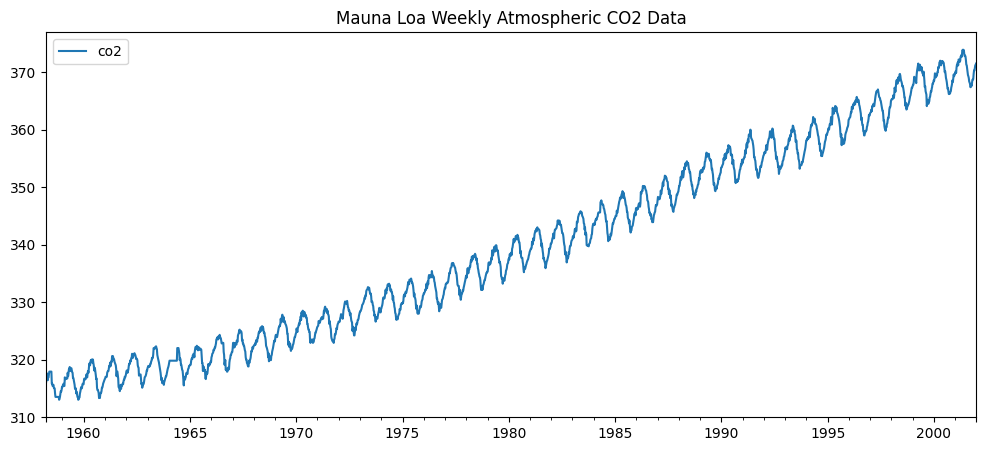

In [ ]:
plt.rcParams["figure.figsize"] = [12, 5]
plpt = co2_df.plot(title=co2.TITLE)

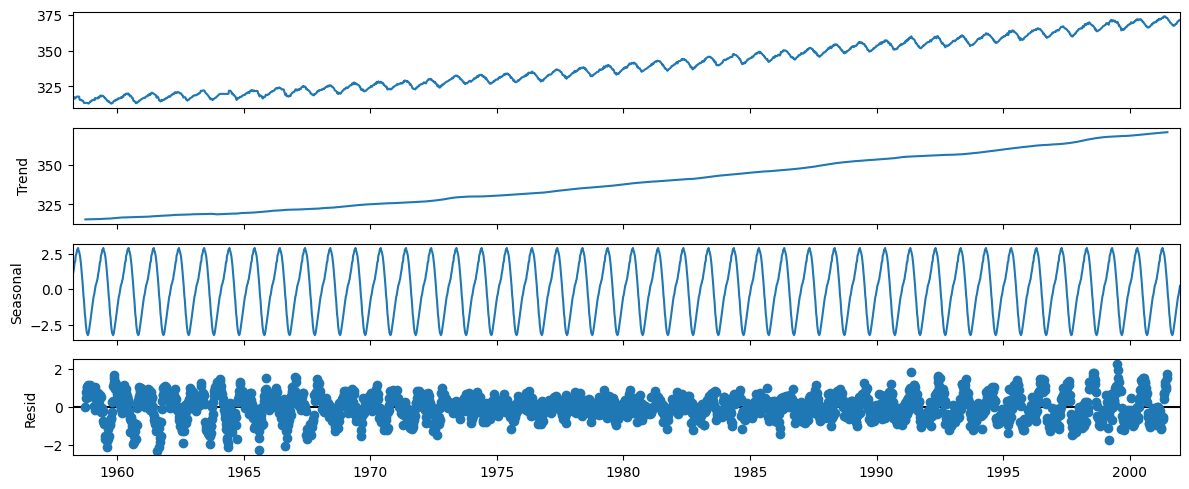

In [ ]:
co2_decomposed = seasonal_decompose(co2_df,model='additive')
plot = co2_decomposed.plot()

### Summary Statistics

- An easy way to check for constant mean and variance is to chop up the data into separate chunks.
- Then, one calculates statistics for each chunk, and compare them.
- Large deviations in either the mean or the variance among chunks might indicate that the time series is nonstationary.
- It's not a rigorous method but gives a good hint of whether the data is approximately stationary or not.

<img src="https://filippomb.github.io/python-time-series-handbook/_images/stationary_chunk.png" style="width: 45%; display: block; margin: auto;">

<img src="https://filippomb.github.io/python-time-series-handbook/_images/nonstationary_chunk.png" style="width: 45%; display: block; margin: auto;">

- Let's look at an example based on the `trend` time series that we created before.

Summary statistics:

In [ ]:
# split data into 10 chunks
num_chunks = 10

# แบ่ง DataFrame เป็น chunks
chunks = np.array_split(co2_df, num_chunks)

In [ ]:
# แสดงผลลัพธ์
print("{}\t | {}\t\t | {}".format("Chunk", "Mean", "Variance"))
print("-" * 35)
for i, chunk in enumerate(chunks, 1):
    mean_val = chunk.mean().values[0]  # ค่าเฉลี่ยของแต่ละ chunk
    var_val = chunk.var().values[0]    # ความแปรปรวนของแต่ละ chunk
    print("{:2}\t | {:.5f}\t | {:.5f}".format(i, mean_val, var_val))

Chunk	 | Mean		 | Variance
-----------------------------------
 1	 | 316.93755	 | 4.55779
 2	 | 319.58210	 | 4.62077
 3	 | 324.15546	 | 5.56774
 4	 | 329.03493	 | 6.81281
 5	 | 334.46009	 | 7.61871
 6	 | 341.27061	 | 8.15592
 7	 | 347.66009	 | 10.05906
 8	 | 354.80351	 | 6.52836
 9	 | 360.68465	 | 10.31981
10	 | 368.18553	 | 9.30248


- While the variance is relatively constant over time, the mean is clearly changing, which means this data is not stationary.
- We do expect some fluctuation in values.
- It's highly unlikely that the either the mean or variance will be exactly the same from chunk to chunk, but it should be close.

- To see this better, it's a good idea to plot the means and variances.
- If you want to be more precise, you could run a statistical test to determine if the difference in means or the difference in variances is statistically significant.

In [ ]:
hpfilter(co2_df)

(1958-03-29   -1.559479
 1958-04-05   -0.285928
 1958-04-12    0.088597
 1958-04-19    0.065250
 1958-04-26   -0.954871
                 ...   
 2001-12-01    0.619135
 2001-12-08    0.969594
 2001-12-15    1.215590
 2001-12-22    1.159358
 2001-12-29    1.202375
 Freq: W-SAT, Name: cycle, Length: 2284, dtype: float64,
 1958-03-29    317.659479
 1958-04-05    317.585928
 1958-04-12    317.511403
 1958-04-19    317.434750
 1958-04-26    317.354871
                  ...    
 2001-12-01    369.680865
 2001-12-08    369.830406
 2001-12-15    369.984410
 2001-12-22    370.140642
 2001-12-29    370.297625
 Freq: W-SAT, Name: trend, Length: 2284, dtype: float64)

In [ ]:
co2_cyclic, co2_trend = hpfilter(co2_df)

<Axes: title={'center': 'CO2 Trend Component'}>

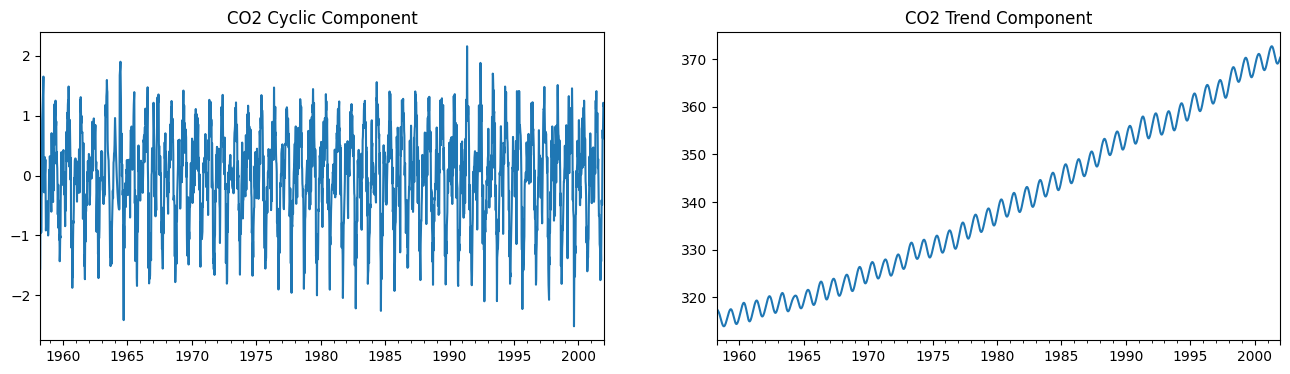

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16, 4))
co2_cyclic.plot(ax=ax[0], title='CO2 Cyclic Component')
co2_trend.plot(ax=ax[1], title='CO2 Trend Component')
#fig.savefig('images/fig_9.18.png', bbox_inches='tight')

In [ ]:
((co2_cyclic + co2_trend) == co2_df['co2']).sum()

2284

### Histogram Plot

- Plotting a histogram of the time series gives important clues into its underlying structure.
- An histogram that looks like a Normal distribution suggests that mean and variance are constant.

- Let's start from the non-stationary time series with trend.

<Axes: ylabel='Frequency'>

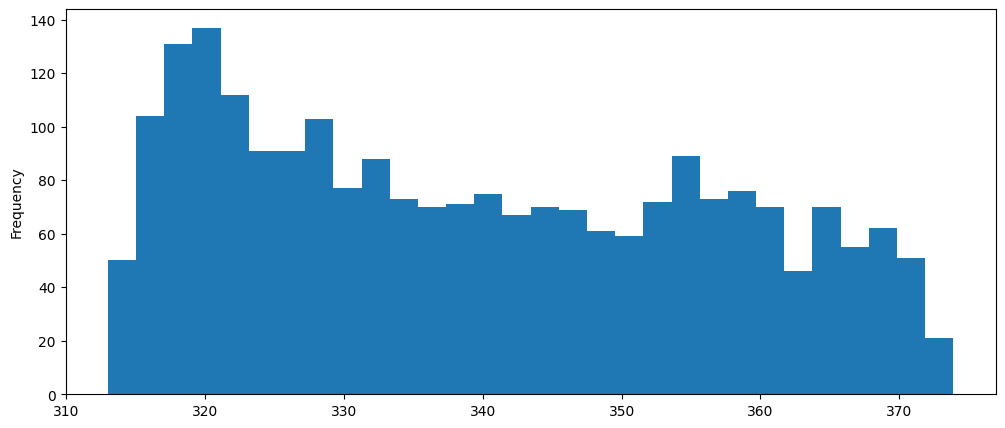

In [ ]:
co2_df['co2'].plot(kind='hist', figsize=(12, 5), bins=30)

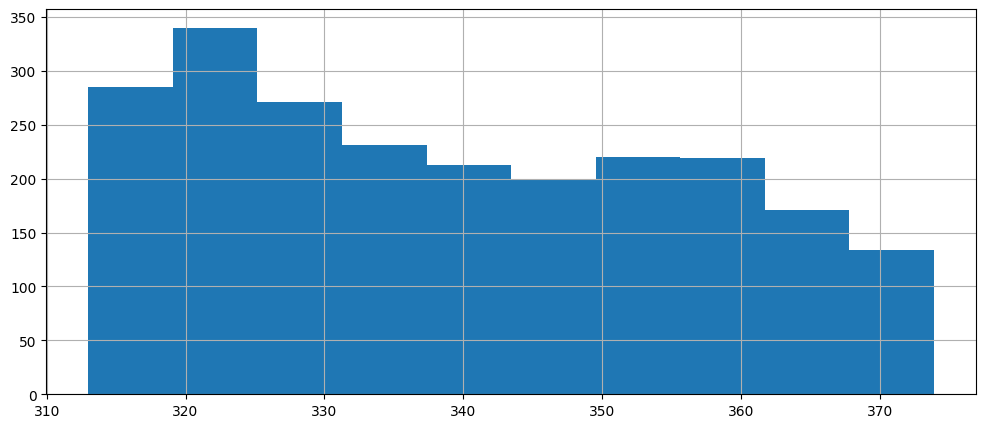

In [ ]:
pd.Series(co2_df['co2']).hist(figsize=(12,5));

- The histogram resembles an *uniform* distribution.
- This is expected since `trend` is, indeed, not stationary.
---

### Augmented Dickey-Fuller Test and Kwiatkowski-Phillips-Schmidt-Shin (KPSS)

- This is a statistical procedure to determine whether a time series is stationary or not.

### การทดสอบความเป็นสถานีด้วยวิธีทางสถิติ
- ในการตรวจสอบความเป็นสถานีของอนุกรมเวลา เราสามารถใช้การทดสอบทางสถิติเช่น Augmented Dickey-Fuller (ADF) Test และ Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test ได้
- การทดสอบเหล่านี้เป็นการทดสอบสมมติฐานทางสถิติที่ใช้ตรวจสอบการมีอยู่ของ "Unit Root" ซึ่งบ่งบอกถึงการที่อนุกรมเวลาไม่เป็นสถานี

### Augmented Dickey-Fuller (ADF) Test:

- สมมติฐานหลัก (Null Hypothesis): มี Unit Root อยู่ในอนุกรมเวลา (non-stationary)
- การตัดสินใจ: ถ้า p-value < 0.05 ให้ปฏิเสธสมมติฐานหลัก แสดงว่าอนุกรมเวลาเป็น stationary

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:

- สมมติฐานหลัก (Null Hypothesis): อนุกรมเวลาเป็น stationary
- การตัดสินใจ: ถ้า p-value < 0.05 ให้ปฏิเสธสมมติฐานหลัก แสดงว่าอนุกรมเวลา non-stationary
---


- Like any statistical test you should set a significance level or threshold that determines whether you should accept or reject the null.
- The values $\alpha=0.05$ or $\alpha=0.01$, which yield a confidence of $95\%$ and $99\%$, respectively, are common choices.

- The ADF test might be inaccurate with small datasets or when heteroskedasticity is present.
- It is best to pair ADF with other techniques (run-sequence plots, summary statistics, histograms, etc..).

### Stationary Data & ADF

- Let's see how to run this test in Python.

In [ ]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(co2_df)

- Let's see and comment the main outputs from the ADF test.

In [ ]:
print(f"ADF: {adf:.2f}")

ADF: 0.05


- First, `adf` is the value of the test statistic.
- The more negative the value, the more confident we can be that the series is stationary.
- That may not mean anything to you just yet but `pvalue` should.

- ADF test statistic ซึ่งใช้ในการทดสอบว่าเราควรปฏิเสธสมมติฐานศูนย์ (𝐻0) ที่ว่าข้อมูลเป็น non-stationary หรือไม่

  - ถ้าค่า ADF มีค่าลบมาก (เช่น -3, -4 เป็นต้น) หมายความว่าเรามีความมั่นใจมากขึ้นว่า series นั้นเป็น stationary
  - ถ้าค่า ADF ใกล้เคียงกับ 0 หรือเป็นบวก (เช่นในกรณีนี้) หมายความว่าเรามีความมั่นใจน้อยลงว่าข้อมูลเป็น stationary และมีแนวโน้มจะเป็น non-stationary

In [ ]:
print(f"p-value: {pvalue}")

p-value: 0.9621787846784345


- The `pvalue` is interpreted like any p-value.
- The `pvalue` should be compared with the confidence levels (e.g., $\alpha=0.05$ or $\alpha=0.01$).
- Based on the comparison, we reject or fail to reject $H_0$.
- Here `pvalue` is very close to 1, so we fail to reject the $H_0$ and conclude that the time series is not stationary.

- p-value ที่เป็นตัวแปรสำคัญที่ช่วยในการตัดสินใจ เราใช้ p-value เพื่อช่วยประเมินว่าเราควรปฏิเสธสมมติฐานศูนย์หรือไม่ โดยทั่วไป:

  - ถ้า p-value ต่ำกว่า 0.05 หรือ 0.01 (ขึ้นอยู่กับระดับนัยสำคัญที่เราตั้งไว้) เราก็จะสามารถปฏิเสธ 𝐻0 และบอกว่าข้อมูลเป็น stationary
  - ถ้า p-value สูงกว่า 0.05 (เช่นในกรณีนี้) เราจะไม่มีหลักฐานเพียงพอในการปฏิเสธ 𝐻0 และข้อมูลจะถูกพิจารณาว่าเป็น non-stationary

In [ ]:
print(f"nobs: {nobs}")

nobs: 2256


- The variable `nobs` is simply the number of observations in the time series.

In [ ]:
print(f"critical values: {critical_values}")

critical values: {'1%': -3.4332519309441296, '5%': -2.8628219967376647, '10%': -2.567452466810334}


- Finally, ``critical_values`` are the test statistic thresholds for common significance levels.
- Here, we see that the test statistic (0.05) is higher than -2.87, -2.57, and -3.43, meaning it is not sufficient to reject $H_0$ at a significance level of 5% or any other common level.

- You may have noticed two outputs we didn't discuss. See statsmodels docs for a description of usedlag and icbest."
- critical_values: เป็นค่าวิกฤติที่ใช้ในการเปรียบเทียบกับสถิติทดสอบ (test statistic) เพื่อทำการทดสอบสมมติฐาน (hypothesis testing) ในกรณีนี้จะมีค่าที่ระดับนัยสำคัญ (significance level) ที่ 1%, 5%, และ 10%
- test statistic (0.05) มีค่าสูงกว่า critical values ทั้งหมดที่ระดับนัยสำคัญ 1%, 5%, และ 10% (คือตัวเลขเช่น -3.43, -2.87 และ -2.57) ซึ่งหมายความว่า:

  - เราไม่สามารถปฏิเสธสมมติฐานศูนย์ (𝐻0) ที่ระดับนัยสำคัญ 5% หรือที่ระดับนัยสำคัญอื่น ๆ ได้
  - นั่นหมายถึงข้อมูลที่ใช้ในแบบทดสอบนี้ไม่มีหลักฐานเพียงพอที่จะบอกว่าเป็น non-stationary ที่ระดับความเชื่อมั่นที่ 5% หรือใดๆ ใน common levels เหล่านี้

- You may have noticed two outputs we didn't discuss.
- See [statsmodels docs](http://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) for a description of ``usedlag`` and ``icbest``.

---

### Stationary Data & KPSS

- Let's see how to run this test in Python.

In [ ]:
kpss_stat, pvalue, n_lags, critical_values = kpss(co2_df)

<ipython-input-19-79bc9a3d9e05>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, pvalue, n_lags, critical_values = kpss(co2_df)


- Let's see and comment the main outputs from the KPSS test.

In [ ]:
print(f"KPSS Statistic: {kpss_stat:.2f}")

KPSS Statistic: 7.65


- First, `kpss_stat` is the value of the test statistic.
- In contrast to the ADF test, a high value for the KPSS test statistic indicates that the series is **not** stationary.



In [ ]:
print(f"p-value: {pvalue}")

p-value: 0.01


- The `pvalue` is interpreted like any p-value.
- If the `pvalue` is lower than the chosen confidence level (e.g., $\alpha=0.05$ or $\alpha=0.01$), we reject the null hypothesis $H_0$ of stationarity.
- Here `pvalue` is less than 0.05, so we reject the null hypothesis the $H_0$ that the series is stationary. Therefore, the data is non-stationary.


In [ ]:
print(f"n_lags: {n_lags}")

n_lags: 29


- The variable `n_lags` indicates the number of lags used in the test.

In [ ]:
print(f"critical values: {critical_values}")

critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


- Finally, `critical_values` are the test statistic thresholds for common significance levels.
- If the test statistic is greater than the critical value at a chosen significance level, we reject the null hypothesis of stationarity.

- Just like with the ADF test, interpreting the results requires a comparison of the test statistic to the critical values.
- See [statsmodels docs](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html) for more information on the parameters and interpretation of `n_lags` and `critical_values`.
---

### Create Function Compare ADF and KPSS

In [ ]:
# use this instead
def print_results(output, test='adf'):

    pval = output[1]
    test_score = output[0]
    lags = output[2]

    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'

    output_dict = {
    'Test Statistic': test_score,
    'p-value': pval,
    'Numbers of lags': lags,
    'decision': decision
    }
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value

    return pd.Series(output_dict, name=test)

In [ ]:
adf_output = adfuller(co2_df)
kpss_output = kpss(co2_df)

<ipython-input-25-1004d1638a95>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_output = kpss(co2_df)


In [ ]:
pd.concat([
print_results(adf_output, 'adf'),
print_results(kpss_output, 'kpss')
], axis=1)

,adf,kpss
Test Statistic,0.046051,7.649196
p-value,0.962179,0.01
Numbers of lags,27,29
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.433252,0.739
Critical Value (5%),-2.862822,0.463
Critical Value (10%),-2.567452,0.347
Critical Value (2.5%),NaN,0.574


In [ ]:
def check_stationarity(df):
    kps = kpss(df)
    adf = adfuller(df)

    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Stationary', 'Non-stationary'

    if adf_pv < 0.05:
        # Reject ADF Null Hypothesis
        adfh = 'Stationary'
    if kpss_pv < 0.05:
        # Reject KPSS Null Hypothesis
        kpssh = 'Non Stationary'
    return (kpssh, adfh)

In [ ]:
check_stationarity(co2_df)

<ipython-input-27-a4566e5e16ef>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kps = kpss(df)


('Non Stationary', 'Non-stationary')

## Common transformations to achieve stationarity

- There are several ways to transform nonstationary time series data:

Transformation | Effect
:---|:---
Subtract trend | Constant mean
Apply log | Constant variance
Differencing | Remove autocorrelation
Seasonal differencing | Remove periodic component

- Often you will have to do several of these on one dataset.
- Note that this is just a small subset of the total possible ways to transform nonstationary time series.

In [ ]:
# using first order differencing (detrending)
first_ord_diff = co2_df.diff().dropna()

# using second order differencing
second_ord_diff = co2_df.diff().diff().dropna()

# differencing to remove seasonality
diseasonalize = co2_df.diff(52).dropna()

# using rolling mean
rolling_mean = co2_df.rolling(window=52).mean()
subt_roll_mean = co2_df - rolling_mean

# log transform
log_transform = np.log(co2_df)

# Square root transform
square_root = np.sqrt(co2_df)

# using seasonal_decompose to remove trend
decomp = seasonal_decompose(co2_df)
sd_detrend = (decomp.observed - decomp.trend)

# using hp_filter
cyclic_extract, trend = hpfilter(co2_df)

# combine the methods into a list
methods = [first_ord_diff, second_ord_diff,
           diseasonalize, subt_roll_mean,
           log_transform, square_root,
           sd_detrend, cyclic_extract]


In [ ]:
def plot_comparison(methods, plot_type='line'):
    n = len(methods) // 2
    fig, ax = plt.subplots(n,2, sharex=True, figsize=(20,10))
    for i, method in enumerate(methods):
        method.dropna(inplace=True)
        name = [n for n in globals() if globals()[n] is method]
        v, r = i // 2, i % 2

        kpss_s, adf_s = check_stationarity(method)

        method.plot(kind=plot_type,
                    ax=ax[v,r],
                    legend=False,
                    title=f'{name[0].upper()} KPSS={kpss_s}, ADF={adf_s}')
        ax[v,r].title.set_size(14)
        method.rolling(52).mean().plot(ax=ax[v,r], legend=False)


In [ ]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
# plt.rc('font', size=8)                     ##
# plt.rc('axes', titlesize=10)               ##
# plt.rc('axes', labelsize=12)               ##
# plt.rc('xtick', labelsize=10)              ##
# plt.rc('ytick', labelsize=10)              ##
# plt.rc('legend', fontsize=10)              ##
# plt.rc('figure', titlesize=10)             ##
#############################################

<ipython-input-27-a4566e5e16ef>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kps = kpss(df)
<ipython-input-27-a4566e5e16ef>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kps = kpss(df)
<ipython-input-27-a4566e5e16ef>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kps = kpss(df)
<ipython-input-27-a4566e5e16ef>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kps = kpss(df)
<ipython-input-27-a4566e5e16ef>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in

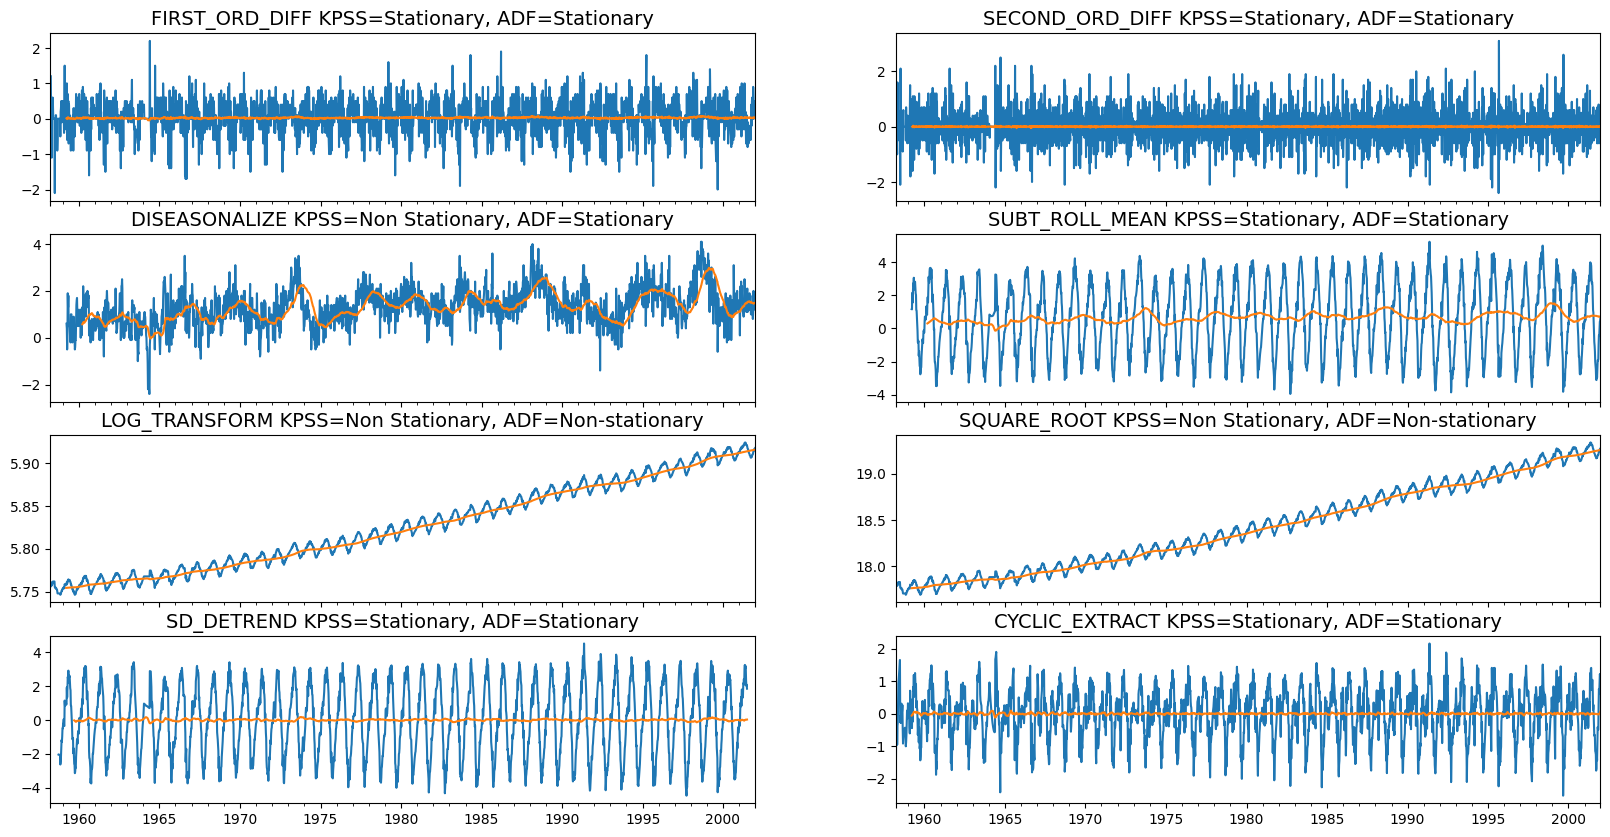

In [ ]:
plot = plot_comparison(methods)
warnings.simplefilter(action='ignore')
#plt.savefig('images/fig_9.20.png', bbox_inches='tight')

## Summary

In this lecture we learned:
1. What does it mean for a time series to be stationary.
2. A set of notable stationary and nonstationary time series.
2. Common tools to identify stationarity.
3. Useful nonstationary-to-stationary transformations.

---

## Exercises

### Exercise 1

- Load the two time series `stationarity_ts1` and `stationarity_ts2` by running the code below.

In [ ]:
# Load the first time series
response = requests.get("https://zenodo.org/records/10897398/files/stationarity_ts1.npy?download=1")
response.raise_for_status()
stationarity_ts1 = np.load(BytesIO(response.content))
print(len(stationarity_ts1))

# Load the second time series
response = requests.get("https://zenodo.org/records/10897398/files/stationarity_ts2.npy?download=1")
response.raise_for_status()
stationarity_ts2 = np.load(BytesIO(response.content))
print(len(stationarity_ts2))

100
100


1. Plot the two time series with a run sequence plot.
4. Based on the plot, discuss if each time series seems to be stationary or not.

### Exercise 2

Use the following tools to determine if the time series `stationarity_ts1` and `stationarity_ts2` are stationary or not.

1. Summary statistics on the chunks.
2. Histogram plots.
3. Augmented Dickey-Fuller test.
4. KPSS test.

Apply the tests and discuss the results obtained with each method. For each series:
- Are the summary statistics and histogram plots indicative of stationarity?
- Do the ADF and KPSS tests confirm stationarity or non-stationarity?

### Exercise 3
If either or both datasets from Exercises 1 and 2 are non-stationary, apply the transformations you learned in this section to make them stationary.

- Differencing: Apply first-order differencing or log transformation.
- Reapply stationarity tests (ADF and KPSS) after transformation to ensure that the time series is now stationary.
- Discussion: Comment on the transformations used and the stationarity results after applying ADF and KPSS tests post-transformation.
